# Monte Carlo Simulation for 2 Stocks: 


# 1. Imports: 
* Import the required libraries
* Install any if missing e.g. `scipy`

In [62]:
import numpy as np 
import pandas as pd 
import datetime
from matplotlib import pyplot as plt
import scipy.stats as st
import datetime
import plotly.express as px
from plotly.offline import iplot


In [2]:
#!pip install scipy

# 2. Data Pre-processing:


## 2.1 data cleaning: 

* Read and clean csv files
* Generate the ratio a: 
$$ a_i =  \frac{x_{close}}{x_{prevclose}}   $$

* Generate the ratio b: 
$$ b_i =  \frac{y_{close}}{y_{prevclose}}   $$
 
* Plot histogram and check distribution
 

In [3]:
hdfcltd  = pd.read_csv("dataset/HDFCLTD.csv")
hdfcbank = pd.read_csv("dataset/HDFCBANK.csv")

hdfcltd["Ratio A"]  =  hdfcltd["Close Price"] / hdfcltd["Prev Close"]
hdfcbank["Ratio B"] =  hdfcbank["Close Price"] / hdfcbank["Prev Close"]

hdfcltd.drop(["Series","Open Price","High Price","Low Price","Last Price","Average Price","Total Traded Quantity","Turnover", "No. of Trades","Deliverable Qty", "% Dly Qt to Traded Qty"], axis=1, inplace=True)

hdfcbank.drop(["Series","Open Price","High Price","Low Price","Last Price","Average Price","Total Traded Quantity","Turnover", "No. of Trades","Deliverable Qty", "% Dly Qt to Traded Qty"], axis=1, inplace=True)


hdfcltd.to_csv("dataset/HDFCLTD-clean.csv", index=False)
hdfcbank.to_csv("dataset/HDFCBANK-clean.csv", index=False)

hdfcltd.drop(["Symbol","Date","Prev Close","Close Price"], axis=1, inplace=True)
hdfcbank.drop(["Symbol","Date","Prev Close","Close Price"], axis=1, inplace=True)


hdfcltd_ratio_a  = hdfcltd["Ratio A"].to_numpy()
hdfcbank_ratio_b = hdfcbank["Ratio B"].to_numpy()

hdfcltd.to_csv("dataset/HDFCLTD-ratio.csv", index=False)
hdfcbank.to_csv("dataset/HDFCBANK-ratio.csv", index=False)




#### NOTE: 
* There were Descrepancies found the data for HDFCBANK on below timestamps: 
  * 14-Jul-2011 - Share price Halved in prevclose but not in close : This is anomalous data. Hence I have manually fixed it
  * 19-Sep-2019 - Share  price Halved in prevclose but not in close : This is anomalous. Hence fixed manually.
* And hence need to read the patched csv file. 
* On Googling this, it was found that stock was split on exactly the same dates but the previous close was not adusted in source NSE data: 

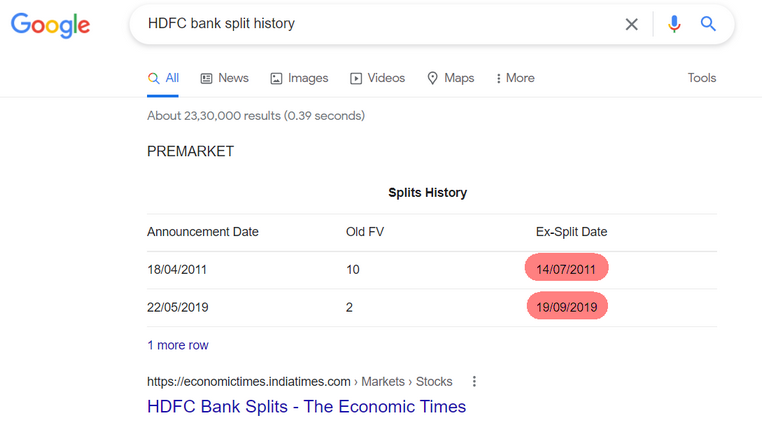
 

* Even the HDFCLTD was split, but luckily we did not had that timeframe in our data. 
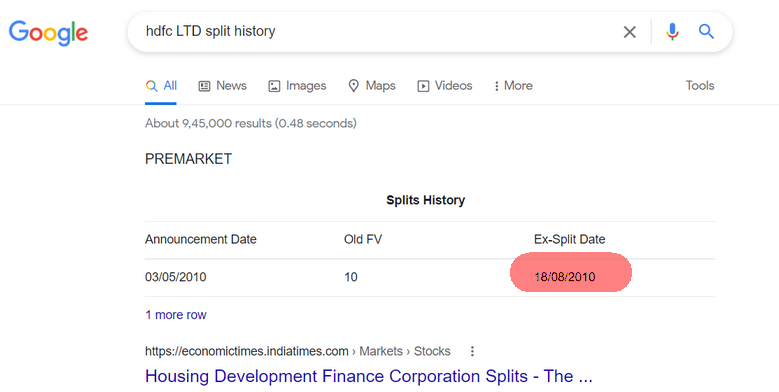

In [4]:
_temp = pd.read_csv("dataset/HDFCBANK-ratio-patched.csv")
hdfcbank_ratio_b = _temp["Ratio B"].to_numpy()

## 2.2 Data preliminary analysis: 

In [5]:
hdfcltd.describe()

,Ratio A
count,2792.000000
mean,1.000650
std,0.018311
min,0.867014
25%,0.990395
50%,1.000217
75%,1.010609
max,1.101882


In [6]:
hdfcbank.describe()

,Ratio B
count,2792.000000
mean,1.000358
std,0.023338
min,0.200798
25%,0.992932
50%,1.000320
75%,1.008260
max,1.115996


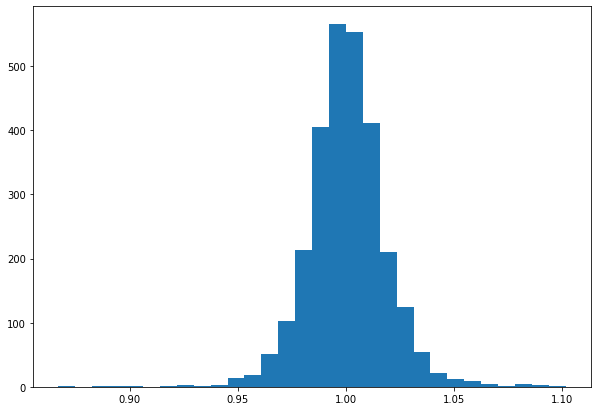

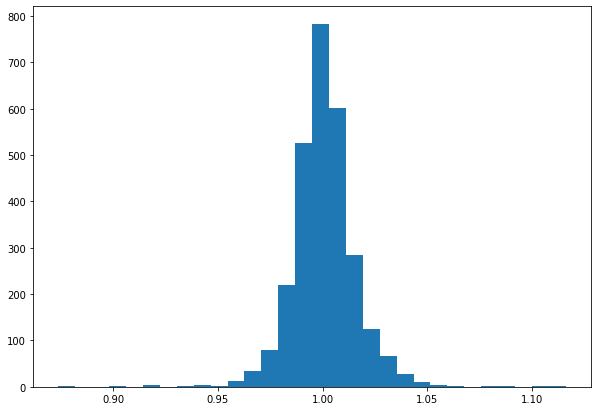

In [7]:
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(hdfcltd_ratio_a,bins=30)
#ax.hist(hdfcltd_ratio_a)

# Show plot
plt.show()

# Creating histogram
fig, by = plt.subplots(figsize =(10, 7))
by.hist(hdfcbank_ratio_b,bins=30)
#by.hist(hdfcbank_ratio_b)

# Show plot
plt.show()

## 2.3 Prepare simulation variables:

In [8]:
# First determine the number of simulations to run which will be stored column wise:
num_simulations = 1000

# Second determine the number of days 
# Next define result dataframes for both stocks:
## HDFC-HDFC Bank Merger: Completion of merger process expected by 2nd or 3rd quarter of FY24
## Fiscal Year 2024 FY24 means the 12-month period commencing on April 1, 2023, and ending on March 31, 2024.
## Q2 FY24 => July-Aug-Sept 2023
## Q3 FY24 => Oct-Nov-Dec 2023

### announced date
date_of_announcement = datetime.datetime.strptime("2022-04-04",'%Y-%m-%d').date()

### Assume the below date
date_of_completion = datetime.datetime.strptime("2023-11-15", '%Y-%m-%d').date()


today = datetime.date.today()

print("date_of_completion: "+str(date_of_completion))
print("date_of_announcement: "+str(date_of_announcement))
print("today: "+str(today))

# Count business days: 
approx_trading_days = np.busday_count( date_of_announcement, date_of_completion)
abs_days            = (date_of_completion-date_of_announcement).days

print("approx_trading_days: "+str(approx_trading_days))
print("Absolute day difference: "+str(abs_days)+" which has about "+str(abs_days-approx_trading_days)+" as weekends.")

n_days = approx_trading_days

date_of_completion: 2023-11-15
date_of_announcement: 2022-04-04
today: 2022-04-06
approx_trading_days: 422
Absolute day difference: 590 which has about 168 as weekends.


# 2.4 Initial Prices of Stocks:

We assume the date reference for calculation is the date of announcement i.e. `04-April-2022`.

On Date `04-April-2022`, the closing prices of stocks were:

### close price of HDFC on 04-April-2022: 2680.05  
### close price of HDFCBANK on 04-April-2022: 1656.80


In [9]:
reference_price_hdfcltd = 2680.05
reference_price_hdfcbank = 1656.80

print(reference_price_hdfcltd)
print(reference_price_hdfcbank)

2680.05
1656.8


# 3. Custom Functions: 

## 3.1 Function-1 for best fit detection for P.D.F. : 

In [10]:
# Yet to be done
## given a stock price df 
## calculate the best fit over the gaussian and save the model into the file
# https://stackoverflow.com/a/51742444/1176573
def get_best_distribution(data, pmf_file=""):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]
    


# 4. Prepare Generator for P.D.F: 

## 4.1 Calculate P.D.F. generator parameters: 

In [11]:
# # https://stackoverflow.com/questions/36256994/how-to-generate-data-from-normal-distribution
# Find Mu and Sigma for both stocks

print("Searching for best fit for HDFCLTD\n")
a_p, a_q, a_r = get_best_distribution(hdfcltd_ratio_a)
print("\n\n")

print("Searching for best fit for HDFCBANK\n")
b_p, b_q, b_r = get_best_distribution(hdfcbank_ratio_b)
print("\n\n")

mu_a, sigma_a = a_r[0], a_r[1]
mu_b, sigma_b = b_r[0], b_r[1]


print("PARAMS for HDFCLTD")
print(a_r)
print("\n\n")

print("PARAMS for HDFCBANK")
print(b_r)
print("\n\n")



Searching for best fit for HDFCLTD

p value for norm = 6.069793784907448e-07
p value for exponweib = 3.6505429715549256e-07
p value for weibull_max = 5.369776537689009e-22
p value for weibull_min = 4.6113010624574795e-23
p value for pareto = 0.0


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2402: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


p value for genextreme = 0.0
Best fitting distribution: norm
Best p value: 6.069793784907448e-07
Parameters for the best fit: (1.000650438098541, 0.018307741877287554)



Searching for best fit for HDFCBANK

p value for norm = 8.62763395512738e-11
p value for exponweib = 5.896092004269332e-14
p value for weibull_max = 0.0
p value for weibull_min = 7.53379718325901e-43
p value for pareto = 0.0
p value for genextreme = 7.709976019909042e-37
Best fitting distribution: norm
Best p value: 8.62763395512738e-11
Parameters for the best fit: (1.0008255409925935, 0.015059697670758087)



PARAMS for HDFCLTD
(1.000650438098541, 0.018307741877287554)



PARAMS for HDFCBANK
(1.0008255409925935, 0.015059697670758087)





## 4.2 Generate Random Samples then Plot and verify: 

* Use Plotly to plot both the distributions original vs artificial side by side and observe.

#### NOTE:
Repeatedly run this section to randomize the data. 


### 4.2.1 Sample for first distribution (normal) fit: 


`exponweib.pdf(x, a, c) =  a * c * (1-exp(-x**c))**(a-1) * exp(-x**c)*x**(c-1)`

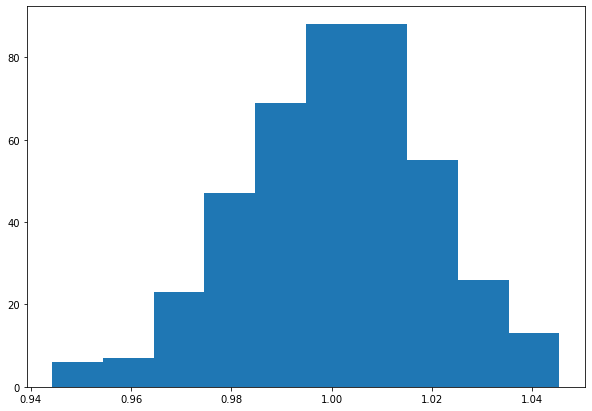

In [12]:

a_artificial_samples = np.random.normal(mu_a, sigma_a, n_days)

# Creating histogram
fig, a_ax = plt.subplots(figsize =(10, 7))
a_ax.hist(a_artificial_samples)

# Show plot
plt.show()



### 4.2.2 Sample for second distribution ( --exponweib-- normal) fit: 

#### Errorneous Data can cause blunder: 

Case study: 

While plotting the ratio data there were two _exceptionally doubtful_ data samples were detected viz., `0.2` and `0.5`. These indicated that all of sudden the share closing price of a a good stock suddenly went down by `80%` and `50%` which raise suspicion. On checking the stock were split and data was not adjusted.    

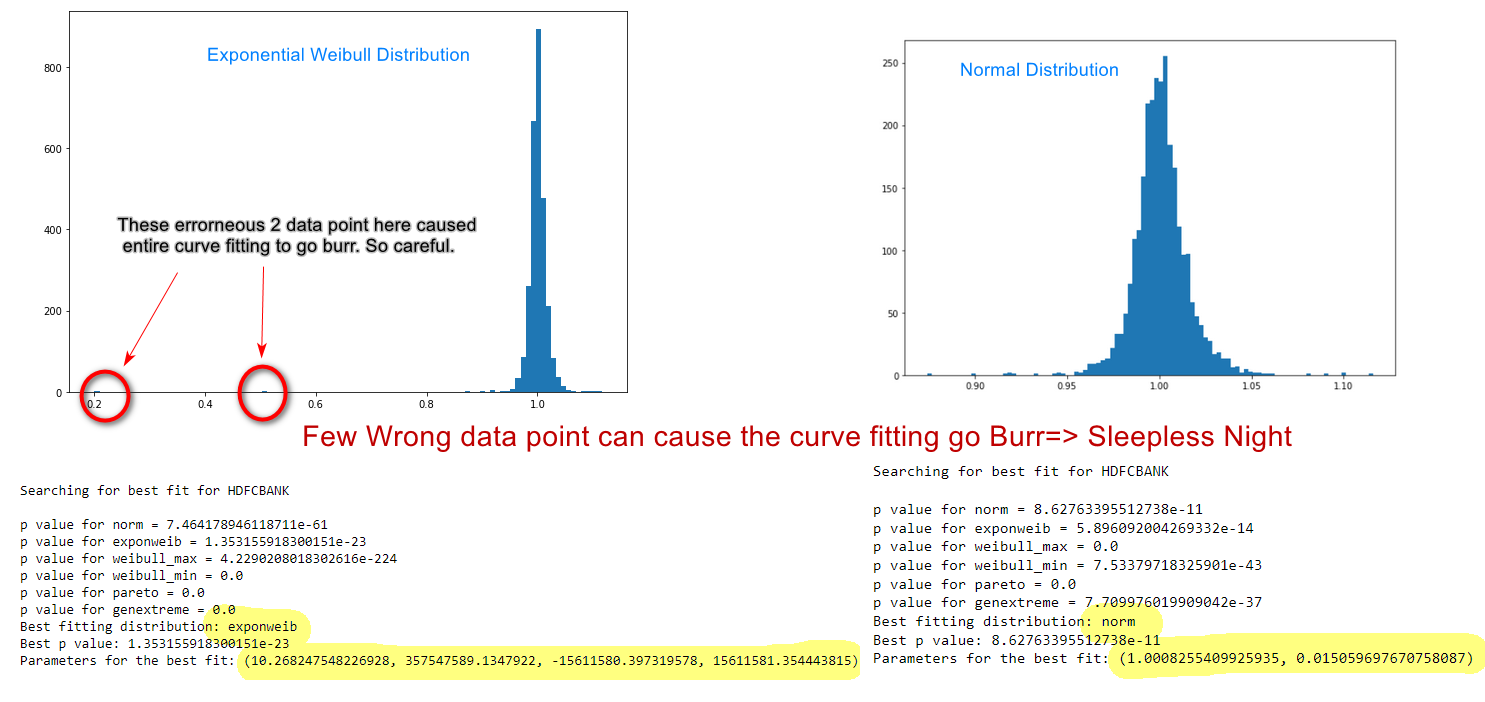

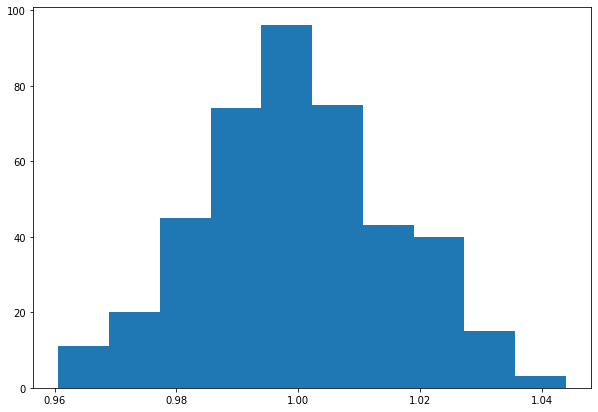

In [13]:
b_artificial_samples = np.random.normal(mu_b, sigma_b, n_days)


# Creating histogram
fig, a_by = plt.subplots(figsize =(10, 7))
a_by.hist(b_artificial_samples)

# Show plot
plt.show()

# 5. Running Monte Carlo:

## 5.1 Algorithm pseduo-code:

Define a function that takes input as ratios dataframe and generates another dataframe representive simulated output:

* Inputs:
  - Initial Price - same for all sim
  - mu - mean of the distribution
  - sigm - stddeb of the distribution 
  - ratio_max - ratio max 
  - ratio_min - ratio min
* Outputs: 
  - CSV Dataframe of size (n X m) = (n_days X m_sims) into file 

* Return: 
  - Dataframe of size (n X m) = (n_days X m_sims) 


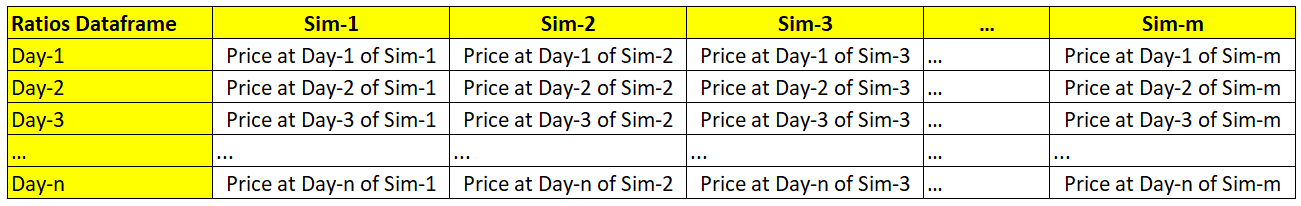




In [14]:
print(reference_price_hdfcltd)
print(reference_price_hdfcbank)

2680.05
1656.8


In [58]:
## Helper function: copied from: https://stackoverflow.com/a/12691993/1176573

import datetime

def date_by_adding_business_days(from_date, add_days):
    import datetime
    business_days_to_add = add_days
    current_date = from_date
    while business_days_to_add > 0:
        current_date += datetime.timedelta(days=1)
        weekday = current_date.weekday()
        if weekday >= 5: # sunday = 6
            continue
        business_days_to_add -= 1
    return current_date

## Monte Carlo function:

def monte_carlo_generator(mu, sigma, r_min, r_max, n_days, start_date, m_sims, initial_value, gen_reports=False):
    result_df = pd.DataFrame()
    result_ratio_df = pd.DataFrame()
    
    
    ## Logic to populate next n_days starting from start_date
    ## WARNING: It is assumed that the start_date passed to this function is NOT a WEEKEND
    ##  Later we can sanitize this behaviour 
    _temp_dates = []
    for i in range(n_days):
        _next_biz_day = date_by_adding_business_days(start_date,i)
        _temp_dates.append(str(_next_biz_day))
        
    result_ratio_df["Date"] = _temp_dates
    result_df["Date"] = _temp_dates
    
    ## Logic to generate ratios dataframe
    sim_column_names = []  ## This will be used for calculation on dataframe 
    for i in range(m_sims):
        _temp_ratios = np.random.normal(mu, sigma, n_days)
        column_name = "sim-"+str(i)
        sim_column_names.append(column_name) 
        result_ratio_df[column_name] = _temp_ratios.tolist()

        
    ## Logic to compute result_df:
    ## 
    for column in sim_column_names:
        sim_i = result_ratio_df[column].to_numpy()
        temp = inefficient_way(sim_i,initial_value)
        result_df[column] = temp
    
    
    if(gen_reports):
        #print("Write the ratios dataframe to a csv file")
        report_filename1 = "output/ratios_"+str(datetime.datetime.now()).replace(" ","-").replace(":","-").replace(".","-") + ".csv"
        report_filename2 = "output/prices_"+str(datetime.datetime.now()).replace(" ","-").replace(":","-").replace(".","-") + ".csv"
        result_ratio_df.to_csv(report_filename1)    
        result_df.to_csv(report_filename2)    
        #print(sim_column_names)
    
    return result_df


def inefficient_way(single_sim_column,initial_value):
    single_col_result = np.array(single_sim_column)
    for i in range(len(single_sim_column)):
        if(i==0):
            single_col_result[0] = single_sim_column[0] * initial_value
        else:
            single_col_result[i] = single_col_result[i] * single_col_result[i-1]
    return single_col_result        

## 5.2 Dipping the toe:

#### For HDFCLTD:

In [65]:
# RUN THIS CELL MY TIMES AS YOU LIKE TO

################# HDFC LTD ###########################

mu = mu_a
sigma = sigma_a

r_min = 0 # Not used
r_max = 0 # Not used
n_days = n_days

#start_date = datetime.datetime.strptime("2022-04-04", "%Y-%m-%d").date()
start_date = date_of_announcement

m_sims = 10
# m_sims = num_simulations

initial_value = reference_price_hdfcltd
gen_reports=False


hdfcltd_mc = monte_carlo_generator(mu, sigma, r_min, r_max, n_days, start_date, m_sims, initial_value, gen_reports)


################# HDFC BANK ###########################

mu = mu_b
sigma = sigma_b

r_min = 0 # Not used
r_max = 0 # Not used
n_days = n_days

#start_date = datetime.datetime.strptime("2022-04-04", "%Y-%m-%d").date()
start_date = date_of_announcement

m_sims = 10
#m_sims = num_simulations

initial_value = reference_price_hdfcbank
gen_reports=False

hdfcbank_mc = monte_carlo_generator(mu, sigma, r_min, r_max, n_days, start_date, m_sims, initial_value, gen_reports)

# plotly express
fig_hdfcltd = px.line(data_frame = hdfcltd_mc, x='Date', y=['sim-0', 'sim-1', 'sim-2', 'sim-3', 'sim-4', 'sim-5', 'sim-6',
       'sim-7', 'sim-8', 'sim-9'])
fig_hdfcltd.show()

fig_hdfcbank = px.line(data_frame = hdfcbank_mc, x='Date', y=['sim-0', 'sim-1', 'sim-2', 'sim-3', 'sim-4', 'sim-5', 'sim-6',
       'sim-7', 'sim-8', 'sim-9'])
fig_hdfcbank.show()

In [56]:
hdfcltd_mc

,Date,sim-0,sim-1,sim-2,sim-3,sim-4,sim-5,sim-6,sim-7,sim-8,sim-9
0,2022-04-04,2680.156437,2639.880343,2634.229838,2696.476228,2591.622510,2688.129806,2714.381083,2731.184863,2655.916562,2651.480806
1,2022-04-05,2640.363713,2661.777559,2657.343549,2676.038809,2552.344626,2698.070709,2729.849647,2659.822821,2711.056996,2631.352708
2,2022-04-06,2650.268537,2626.416590,2730.549769,2602.929003,2600.377615,2720.993068,2746.629605,2698.454747,2765.163276,2593.053206
3,2022-04-07,2657.241388,2620.833621,2749.377034,2574.618869,2564.474171,2680.867008,2652.816701,2661.552395,2756.496301,2529.577214
4,2022-04-08,2641.585713,2674.384589,2808.265176,2513.403786,2525.049247,2655.620814,2676.363299,2652.452799,2740.312959,2514.392505
...,...,...,...,...,...,...,...,...,...,...,...
417,2023-11-08,2783.109489,1927.600310,2231.164463,3344.129816,2921.990369,5691.857647,1101.041002,2467.605222,2720.272518,3457.655422
418,2023-11-09,2800.919196,1907.903845,2221.159048,3242.097811,2882.968991,5650.838563,1130.384417,2531.755520,2698.659360,3462.467290
419,2023-11-10,2826.645200,1885.394146,2176.046437,3060.349195,2928.811136,5675.662933,1134.218301,2500.948904,2758.129160,3425.315094
420,2023-11-13,2811.210150,1899.538152,2182.710060,3115.628127,2833.897126,5631.854528,1143.426797,2433.354844,2708.079348,3471.934674


In [57]:
hdfcbank_mc

,Date,sim-0,sim-1,sim-2,sim-3,sim-4,sim-5,sim-6,sim-7,sim-8,sim-9
0,2022-04-04,1666.240918,1651.093179,1661.748599,1656.961684,1633.747864,1665.994839,1672.026162,1676.108096,1638.174933,1607.686218
1,2022-04-05,1688.617666,1681.756136,1680.159095,1634.464812,1633.055848,1680.326191,1655.528678,1657.245864,1630.352165,1570.614847
2,2022-04-06,1693.094913,1702.516617,1651.942495,1617.346860,1643.110506,1688.659667,1688.727178,1681.526435,1625.965490,1587.932103
3,2022-04-07,1682.969309,1699.929965,1678.307924,1637.922337,1665.440302,1685.307439,1655.190430,1641.335595,1598.642474,1588.188230
4,2022-04-08,1668.661258,1692.822533,1672.671013,1647.649628,1667.829134,1714.917727,1684.663066,1658.631995,1617.443381,1582.514664
...,...,...,...,...,...,...,...,...,...,...,...
417,2023-11-08,1726.215291,2287.143018,1003.448222,2128.572330,1805.048041,2425.273014,2792.682445,2117.044845,2208.120201,2242.851346
418,2023-11-09,1730.664319,2274.970464,991.031431,2176.347810,1814.463284,2460.927681,2753.047649,2095.467339,2204.051458,2223.720094
419,2023-11-10,1723.026084,2253.905858,982.707601,2174.615526,1791.158322,2507.951962,2774.713383,2094.626572,2222.772277,2173.035700
420,2023-11-13,1704.328191,2247.268848,961.855312,2166.734433,1800.021641,2606.988830,2732.147290,2049.857713,2216.226644,2151.597928


## 5.3 Running large Monte Carlo simulations :



In [72]:
# RUN THIS CELL MY TIMES AS YOU LIKE TO

################# HDFC LTD ###########################

mu = mu_a
sigma = sigma_a

r_min = 0 # Not used
r_max = 0 # Not used
n_days = n_days

#start_date = datetime.datetime.strptime("2022-04-04", "%Y-%m-%d").date()
start_date = date_of_announcement

#m_sims = 10
m_sims = num_simulations

initial_value = reference_price_hdfcltd
gen_reports=True


hdfcltd_mc = monte_carlo_generator(mu, sigma, r_min, r_max, n_days, start_date, m_sims, initial_value, gen_reports)


################# HDFC BANK ###########################

mu = mu_b
sigma = sigma_b

r_min = 0 # Not used
r_max = 0 # Not used
n_days = n_days

#start_date = datetime.datetime.strptime("2022-04-04", "%Y-%m-%d").date()
start_date = date_of_announcement

#m_sims = 10
m_sims = num_simulations

initial_value = reference_price_hdfcbank
gen_reports=True

hdfcbank_mc = monte_carlo_generator(mu, sigma, r_min, r_max, n_days, start_date, m_sims, initial_value, gen_reports)


######################## PLOTTING RESULTS OF SIMULATION ###################

# plotly express

#### WARNING HORRIBALE IDEA TO PLAOT ALL 1000 Line Charts !!! YOUR BROWSER MAY CRASH
## fig_hdfcltd = px.line(data_frame = hdfcltd_mc, x='Date', y=hdfcltd_mc.filter(like='sim-').columns)
fig_hdfcltd = px.line(data_frame = hdfcltd_mc, x='Date', y=['sim-0', 'sim-1', 'sim-2', 'sim-3', 'sim-4', 'sim-5', 'sim-6',
       'sim-7', 'sim-8', 'sim-9'])
fig_hdfcltd.show()

#### WARNING HORRIBALE IDEA TO PLAOT ALL 1000 Line Charts !!! YOUR BROWSER MAY CRASH
## fig_hdfcbank = px.line(data_frame = hdfcbank_mc, x='Date', y=hdfcbank_mc.filter(like='sim-').columns)
fig_hdfcbank = px.line(data_frame = hdfcbank_mc, x='Date', y=['sim-0', 'sim-1', 'sim-2', 'sim-3', 'sim-4', 'sim-5', 'sim-6',
       'sim-7', 'sim-8', 'sim-9'])
fig_hdfcbank.show()




# 6. Calculating the Simulated Probability of Profitability 


## 6.1 Profitability Definition:

P(b>a) at f